##RetinaNet Implementation on TF 1.x


In [0]:
%tensorflow_version 1.x
!git clone https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [0]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170078 sha256=a05a038401d60d111deb2bf10e614e702b8a7b0452ea8fbf9e69b1078b01d82a
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 0.5.1
    Uninstalling keras-retinanet-0.5.1:
      Successfully uninstalled keras-retinanet-0.5.1


In [0]:
!python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [0]:
import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas
from google.colab import drive
from google.colab import files

# Making Dataset

We will be using HyperLabel to create our dataset. You can watch the following tutorial video about how to use HyperLabel and tag images with it.

https://www.youtube.com/embed/R56Ck3tElIs

Once all of your images are tagged, its time to export the labels and data in Pascal VOC format. Goto the `review` tab/section and click on the export button. From the export menu, choose `Object Detection` and select Pascal VOC and click on export. It will take some time to export the data, once exported you should be able to see multiple folders, but we are interested in two i.e., `Annotations` and `JPEGImages` folder.

Now created a new folder, name it `dataset`. Copy all the contents of `Annotations` folder and `JPEGImages` folder inside `dataset` folder and then create a zip archive of this folder.

Upload this zip archive to your Google drive and get the ID. To locate the File ID, right click on the name of the file, choose the Get Shareable Link option, and turn on Link Sharing if needed (you can turn it off later). You will see the link with a combination of numbers and letters at the end, and what you see after id =   is the File ID.

https://drive.google.com/open?id=***ThisIsFileID*** 

If your file is already open in a browser, you can obtain File ID from its link:

https://docs.google.com/spreadsheets/d/***ThisIsFileID***/edit#gid=123456789 

In [0]:
DATASET_DRIVEID = '10g4lvriaygc6i5fvk0xCOiA9SVRkxwr0'

In [0]:
DATASET_DIR = 'dataset'
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [0]:
drive_url = 'https://drive.google.com/uc?export=download&id=' + DATASET_DRIVEID
file_name = DATASET_DRIVEID + '.zip'

urllib.request.urlretrieve(drive_url, file_name)
print('Download completed!')

os.makedirs(DATASET_DIR, exist_ok=True)
with zipfile.ZipFile(file_name, 'r') as zip_ref:
  zip_ref.extractall(DATASET_DIR)
os.remove(file_name)

print('Extract completed!')

Download completed!
Extract completed!


In [0]:
annotations = []
classes = set([])

for xml_file in [f for f in os.listdir(DATASET_DIR) if f.endswith(".xml")]:
  tree = ET.parse(os.path.join(DATASET_DIR, xml_file))
  root = tree.getroot()

  file_name = None

  for elem in root:
    if elem.tag == 'filename':
      file_name = os.path.join(DATASET_DIR, elem.text)

    if elem.tag == 'object':
      obj_name = None
      coords = []
      for subelem in elem:
        if subelem.tag == 'name':
          obj_name = subelem.text
        if subelem.tag == 'bndbox':
          xmin = ""
          xmax = ""
          ymin = ""
          ymax = ""
          for subsubelem in subelem:
            f = float(subsubelem.text)
            i = int(f)
            if subsubelem.tag == "xmin":
              xmin = str(i)
            if subsubelem.tag == "xmax":
              xmax = str(i)
            if subsubelem.tag == "ymin":
              ymin = str(i)
            if subsubelem.tag == "ymax":
              ymax = str(i)
          
          coords.append(xmin)
          coords.append(ymin)
          coords.append(xmax)
          coords.append(ymax)
            
      item = [file_name] + coords + [obj_name]
      annotations.append(item)
      classes.add(obj_name)

with open(ANNOTATIONS_FILE, 'w') as f:
  writer = csv.writer(f)
  writer.writerows(annotations)

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(classes):
    f.write('{},{}\n'.format(line,i))

In [0]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

#### OPTION 1: Pre Trained ResNet 50
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

#### OPTION 2: Custom model from GOOGLE DRIVE. CHANGE DRIVE_MODEL VALUE. 
#drive.mount('/content/gdrive')
#DRIVE_MODEL = '/content/gdrive/My Drive/Colab Notebooks/resnet50_csv_10.h5'
#shutil.copy(DRIVE_MODEL, './snapshots/resnet50_csv_10.h5')


print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [0]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 10 csv annotations.csv classes.csv

Using TensorFlow backend.
Creating model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 9) vs (720, 256, 3, 3)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((9,) vs (720,)).
  weight_values[i].shape))
2020-05-02 07:08:35.162481: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-02 07:08:35.177806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-02 07:08:35.178745: I tensorflow/co

In [0]:
#### OPTIONAL: EXPORT TRAINED MODEL TO DRIVE ####
drive.mount('/content/gdrive')
COLAB_MODEL = './snapshots/resnet50_csv_10.h5'
DRIVE_DIR = '/content/gdrive/My Drive/Colab Notebooks/'
shutil.copy(COLAB_MODEL, DRIVE_DIR)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/Colab Notebooks/resnet50_csv_10.h5'

In [0]:
THRES_SCORE = 0.8

In [0]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
#tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config));
keras.backend.tensorflow_backend.set_session(get_session())

In [0]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pandas.read_csv(CLASSES_FILE,header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_10.h5
tracking <tf.Variable 'Variable_5:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_6:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_7:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_8:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_9:0' shape=(9, 4) dtype=float32> anchors


In [0]:
def img_inference(img_path):
  image = read_image_bgr(img_infer)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < THRES_SCORE:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      print(caption)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

Saving 20190220_155839.jpg to 20190220_155839.jpg
Running inference on: 20190220_155839.jpg
processing time:  4.190868854522705
goat 0.999
goat 0.998
goat 0.979


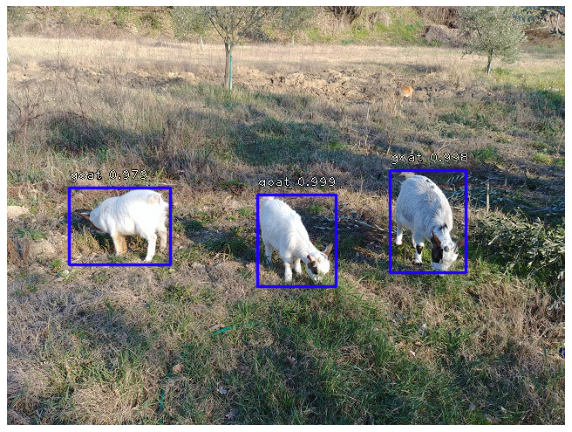

In [0]:

uploaded = files.upload()
img_infer = list(uploaded)[0]

print('Running inference on: ' + img_infer)
img_inference(img_infer)